In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = pd.read_csv('burglaries_preprocessed.csv')
data = data[['Month', 'Ward']]

In [44]:
def reg_evaluation(y_test, y_pred, ward: str):    
    print(f'Results for {ward}:')
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred),2))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
    print('R2 score:', round(r2_score(y_test, y_pred),2))

In [4]:
def create_features(df):

    df = df.set_index('Month')
    df.index = pd.to_datetime(df.index)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['crime_count'] = 1
    
    return df

data = create_features(data)

In [5]:
def return_year_month(row):
    return str(row['year']) + '-' + str(row['month'])

In [6]:
data

,Ward,quarter,month,year,crime_count
Month,,,,,
2010-12-01,High Barnet,4,12,2010,1
2010-12-01,High Barnet,4,12,2010,1
2010-12-01,High Barnet,4,12,2010,1
2010-12-01,High Barnet,4,12,2010,1
2010-12-01,High Barnet,4,12,2010,1
...,...,...,...,...,...
2023-03-01,Childs Hill,1,3,2023,1
2023-03-01,Childs Hill,1,3,2023,1
2023-03-01,Childs Hill,1,3,2023,1


In [7]:
data_aggr = data.groupby(['year', 'month', 'Ward', 'quarter']).count()
data_aggr.reset_index(inplace=True)

In [8]:
data_aggr.loc[450:500]

,year,month,Ward,quarter,crime_count
450,2012,6,Totteridge & Woodside,2,13
451,2012,6,Underhill,2,21
452,2012,6,West Finchley,2,23
453,2012,6,West Hendon,2,16
454,2012,6,Whetstone,2,19
455,2012,6,Woodhouse,2,27
456,2012,7,Barnet Vale,3,12
457,2012,7,Brunswick Park,3,10
458,2012,7,Burnt Oak,3,19
459,2012,7,Childs Hill,3,26


In [9]:
data_aggr['year_month'] = data_aggr.apply(return_year_month, axis=1)

data_aggr = data_aggr.set_index('year_month')
data_aggr.index = pd.to_datetime(data_aggr.index)

In [43]:
print('Missing months per ward: \n')

for i in data_aggr['Ward'].unique():
    if data_aggr[data_aggr['Ward']==i].shape[0]<148:
        print(i, 148-data_aggr[data_aggr['Ward']==i].shape[0])

Missing months per ward: 

Colindale North 1
Colindale South 1
Edgwarebury 1
High Barnet 1
Totteridge & Woodside 1
Whetstone 1
Woodhouse 1


In [11]:
data_aggr.index

DatetimeIndex(['2010-12-01', '2010-12-01', '2010-12-01', '2010-12-01',
               '2010-12-01', '2010-12-01', '2010-12-01', '2010-12-01',
               '2010-12-01', '2010-12-01',
               ...
               '2023-03-01', '2023-03-01', '2023-03-01', '2023-03-01',
               '2023-03-01', '2023-03-01', '2023-03-01', '2023-03-01',
               '2023-03-01', '2023-03-01'],
              dtype='datetime64[ns]', name='year_month', length=3545, freq=None)

In [12]:
# train = data_aggr[data_aggr['year']<2022]
# val = data_aggr[(data_aggr['year']==2022) & (data_aggr['month']<=7)]
# test = pd.concat([data_aggr[(data_aggr['year']==2022) & (data_aggr['month']>7)], 
#                  data_aggr[(data_aggr['year']>2022)]])


train = data_aggr.loc[data_aggr.index < '2022-01-01']
val = data_aggr.loc[data_aggr.index < '2022-08-01']
val = pd.concat([train,val]).drop_duplicates(keep=False)
test = data_aggr.loc[data_aggr.index >= '2022-08-01']

In [13]:
val

,year,month,Ward,quarter,crime_count
year_month,,,,,
2022-01-01,2022,1,Barnet Vale,1,5
2022-01-01,2022,1,Brunswick Park,1,9
2022-01-01,2022,1,Burnt Oak,1,9
2022-01-01,2022,1,Childs Hill,1,15
2022-01-01,2022,1,Colindale North,1,10
...,...,...,...,...,...
2022-07-01,2022,7,Underhill,3,2
2022-07-01,2022,7,West Finchley,3,6
2022-07-01,2022,7,West Hendon,3,8


In [14]:
FEATURES = ['quarter', 'month', 'year', 'Ward']
TARGET = 'crime_count'

X_train = train[FEATURES]
y_train = train[TARGET]

X_val = val[FEATURES]
y_val = val[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
X_val

,quarter,month,year
year_month,,,
2022-01-01,1,1,2022
2022-01-01,1,1,2022
2022-01-01,1,1,2022
2022-01-01,1,1,2022
2022-01-01,1,1,2022
...,...,...,...
2022-07-01,3,7,2022
2022-07-01,3,7,2022
2022-07-01,3,7,2022


# Model 1 - predicting crime rate for 1 ward

In [16]:
FEATURES = ['quarter', 'month', 'year']
TARGET = 'crime_count'

def data_split_1_ward(data, ward, end_train, end_val):
    
    WARD = ward
    data_1w = data[data['Ward']==WARD]
    train_1w = data.loc[data.index < end_train]
    val_1w = data.loc[data.index < end_val]
    val_1w = pd.concat([train,val]).drop_duplicates(keep=False)
    test_1w = data.loc[data.index >= end_val]
    
    return train_1w, val_1w, test_1w

In [75]:
train_childs_hill, val_childs_hill, test_childs_hill = data_split_1_ward(data_aggr.loc[data_aggr.index >= '2020-03-01'], 
                                                        'Childs Hill', '2022-01-01', '2022-08-01')

# CURRENTLY THIS IS THE COVID TIME PERIOD
# IT HAS A DIFFERENT CRIMINAL PATTERN, BC FOR THE WHOLE DATA THE TOP FEATURE IS YEAR, BUT FOR COVID ITS QUARTER

In [76]:
X_train_childs_hill = train_childs_hill[FEATURES]
y_train_childs_hill = train_childs_hill[TARGET]

X_val_childs_hill = val_childs_hill[FEATURES]
y_val_childs_hill = val_childs_hill[TARGET]

X_test_childs_hill = test_childs_hill[FEATURES]
y_test_childs_hill = test_childs_hill[TARGET]

In [77]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train_childs_hill, y_train_childs_hill, eval_set=[(X_train_childs_hill, y_train_childs_hill), 
                                                            (X_val_childs_hill, y_val_childs_hill)], verbose=100)


[20:53:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9.32752	validation_1-rmse:13.83997
[100]	validation_0-rmse:5.36343	validation_1-rmse:9.61951
[200]	validation_0-rmse:4.51656	validation_1-rmse:8.35339
[300]	validation_0-rmse:4.37963	validation_1-rmse:7.99291
[400]	validation_0-rmse:4.35185	validation_1-rmse:7.86471
[500]	validation_0-rmse:4.34761	validation_1-rmse:7.82438
[600]	validation_0-rmse:4.34656	validation_1-rmse:7.81026
[700]	validation_0-rmse:4.34359	validation_1-rmse:7.81342
[717]	validation_0-rmse:4.34261	validation_1-rmse:7.81499


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [78]:
reg_evaluation(y_test_childs_hill, reg.predict(X_test_childs_hill), 'Childs hill')
# R2 is sus, very poor

Results for Childs hill:
Mean Absolute Error: 4.01
Root Mean Squared Error: 5.26
R2 score: -0.02


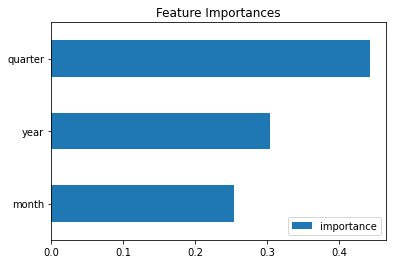

In [79]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importances')
plt.show()

